### Importing packages

In [1]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import scipy.stats as sts 
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr

from helpers import *
import cca_helpers

### Loading Data

In [7]:
data_path = r'/home/teachinglab/Documents/comm-project/data'

trial_inf = trial_info(data_path + r"/ab042_trial_data.csv")
neuron_inf = neuron_info(data_path + r"/ab042_cluster_spike_times.csv")
spike_array = np.load(data_path + r"/ab042_spikes_dense.npy")

In [8]:
print(f"Trial types: {trial_inf.trial_types}")

Trial types: ['Auditory Hit', 'Auditory Miss', 'Whisker Hit', 'Whisker Miss', 'False Alarm', 'Correct Rejection']


In [14]:
trial_type = ["Auditory Hit"]
area_1 = "tjM1"
area_2 = "DLS"

area1_spikes = filter_data(spike_array, trial_inf, neuron_inf, trial_type, [area_1, area_2])[trial_type[0]][area_1]
area2_spikes = filter_data(spike_array, trial_inf, neuron_inf, trial_type, [area_1, area_2])[trial_type[0]][area_2]

In [16]:
#Here we slice the array and we smooth

pre_win = 10
post_win = 100

kernel_size = 5


proc_area_1 = slice_array(area1_spikes, pre_win, post_win, smooth=True, smooth_kernel = kernel_size)
proc_area_2 = slice_array(area2_spikes, pre_win, post_win, smooth=True, smooth_kernel = kernel_size)

In [17]:
print(proc_area_1.shape)
print(proc_area_2.shape)

(166, 83, 110)
(135, 83, 110)


In [18]:
#Here we concatenate all trials and split into train and test

area1_tr, area1_te = split_reshape(proc_area_1)
area2_tr, area2_te = split_reshape(proc_area_1)

In [20]:
print(f"Area1 train: {area1_tr.shape}, Area1 test: {area1_te.shape}")
print(f"Area2 train: {area2_tr.shape}, Area2 test: {area2_te.shape}")

Area1 train: (166, 4510), Area1 test: (166, 4510)
Area2 train: (166, 4510), Area2 test: (166, 4510)


In [21]:
#Here we mean center the data

X1_tr = area1_tr - area1_tr.mean(axis=1)[:,np.newaxis]
X1_te = area1_te - area1_tr.mean(axis=1)[:,np.newaxis]
X2_tr = area2_tr - area2_tr.mean(axis=1)[:,np.newaxis]
X2_te = area2_te - area2_tr.mean(axis=1)[:,np.newaxis]

### Getting ready for CCA

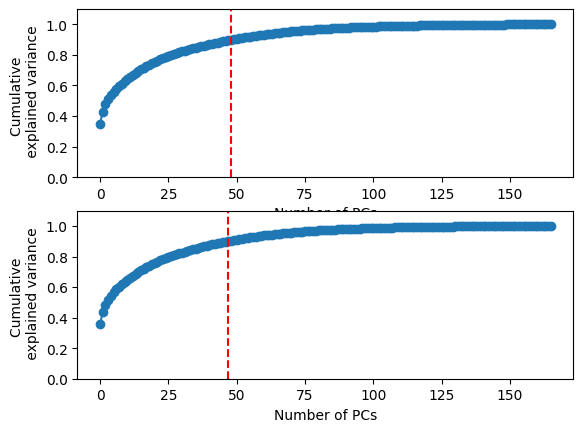

In [22]:
#Here we find the number of PCs that need to be kept

pca1 = PCA()
pca1.fit(X1_tr.T)

pca2 = PCA()
pca2.fit(X2_tr.T)

fig, axs = plt.subplots(2,1)
for ax in axs.flat:
    ax.set_ylim(0,1.1)
    ax.set_ylabel('Cumulative \n explained variance')
    ax.set_xlabel('Number of PCs')
    
axs[0].plot(np.cumsum(pca1.explained_variance_ratio_), marker="o")
axs[0].axvline(np.argmin(np.abs(np.cumsum(pca1.explained_variance_ratio_)-0.9)), linestyle="--", c="red")
axs[1].plot(np.cumsum(pca2.explained_variance_ratio_), marker="o")
axs[1].axvline(np.argmin(np.abs(np.cumsum(pca2.explained_variance_ratio_)-0.9)), linestyle="--", c="red")

keep_pcs = max(np.argmin(np.abs(np.cumsum(pca1.explained_variance_ratio_)-0.9)), 
               np.argmin(np.abs(np.cumsum(pca2.explained_variance_ratio_)-0.9)))

if keep_pcs >= min(X1_tr.shape(0), X1_tr.shape(0)):
    keep_pcs = min(X1_tr.shape(0), X1_tr.shape(0))
    
